In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure

In [23]:
N = 50
init_random = np.random.random((N,N))
lattice_n = np.zeros((N, N))
lattice_n[init_random>=0.75] = 1
lattice_n[init_random<0.75] = -1

init_random = np.random.random((N,N))
lattice_p = np.zeros((N, N))
lattice_p[init_random>=0.25] = 1
lattice_p[init_random<0.25] = -1

In [25]:
def get_energy(lattice):
    # applies the nearest neighbours summation
    kern = generate_binary_structure(2, 1) 
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)
    return arr.sum()


In [26]:
get_energy(lattice_p)

-2640.0

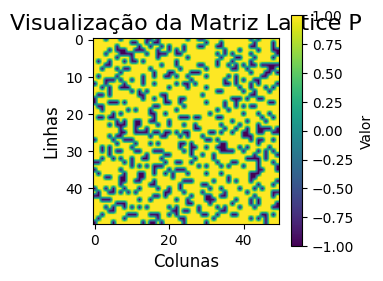

In [30]:
# Plotar a matriz lattice_p
plt.figure(figsize=(3, 3))  # Ajustar o tamanho da figura para melhor visualização
plt.imshow(lattice_p, cmap='viridis', interpolation='bilinear')  # Adicionar mapa de cores
plt.colorbar(label='Valor')  # Adicionar a barra de cores com rótulo

# Adicionar título e rótulos aos eixos
plt.title('Visualização da Matriz Lattice P', fontsize=16)
plt.xlabel('Colunas', fontsize=12)
plt.ylabel('Linhas', fontsize=12)

# Exibir o gráfico
plt.show()

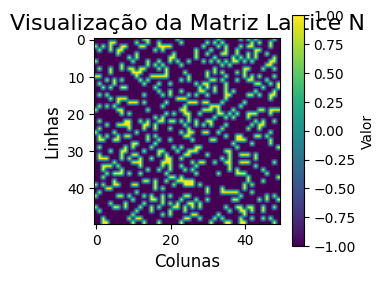

In [31]:
# Plotar a matriz lattice_p
plt.figure(figsize=(3, 3))  # Ajustar o tamanho da figura para melhor visualização
plt.imshow(lattice_n, cmap='viridis', interpolation='bilinear')  # Adicionar mapa de cores
plt.colorbar(label='Valor')  # Adicionar a barra de cores com rótulo

# Adicionar título e rótulos aos eixos
plt.title('Visualização da Matriz Lattice N', fontsize=16)
plt.xlabel('Colunas', fontsize=12)
plt.ylabel('Linhas', fontsize=12)

# Exibir o gráfico
plt.show()

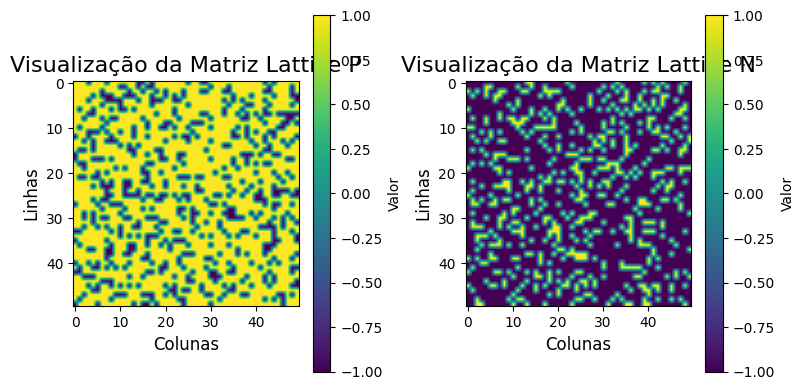

In [32]:
# Criar uma figura com dois subplots (um para cada matriz)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))  # 1 linha, 2 colunas

# Plotar a matriz lattice_p
cax1 = ax[0].imshow(lattice_p, cmap='viridis', interpolation='bilinear')
fig.colorbar(cax1, ax=ax[0], label='Valor')  # Adicionar a barra de cores com rótulo no subplot da esquerda
ax[0].set_title('Visualização da Matriz Lattice P', fontsize=16)
ax[0].set_xlabel('Colunas', fontsize=12)
ax[0].set_ylabel('Linhas', fontsize=12)

# Plotar a matriz lattice_n
cax2 = ax[1].imshow(lattice_n, cmap='viridis', interpolation='bilinear')
fig.colorbar(cax2, ax=ax[1], label='Valor')  # Adicionar a barra de cores com rótulo no subplot da direita
ax[1].set_title('Visualização da Matriz Lattice N', fontsize=16)
ax[1].set_xlabel('Colunas', fontsize=12)
ax[1].set_ylabel('Linhas', fontsize=12)

# Ajustar layout para evitar sobreposição
plt.tight_layout()

# Exibir o gráfico
plt.show()


In [27]:
@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy):
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        # 2. pick random point on array and flip spin
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] #initial spin
        spin_f = spin_i*-1 #proposed spin flip
        
        # compute change in energy
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        
        # 3 / 4. change state with designated probabilities
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
            
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
            
    return net_spins, net_energy


In [70]:
bj = 0.2
spins, energies = metropolis(lattice_n, 1000000, bj, get_energy(lattice_n))

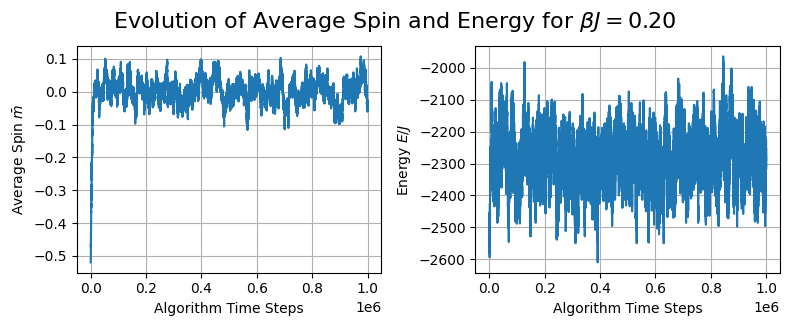

In [71]:
#À esquerda: A média dos spins (spins/N**2) ao longo dos passos do algoritmo, o que pode representar a evolução do magnetismo médio no sistema.
#À direita: A energia do sistema (energies) ao longo dos passos do algoritmo.

# Criação dos gráficos
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Gráfico da média dos spins
ax = axes[0]
ax.plot(spins / N**2)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()

# Gráfico da energia
ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()

# Adiciona o título com o valor de βJ formatado
fig.tight_layout()
fig.suptitle(r'Evolution of Average Spin and Energy for $\beta J=$' + f'{bj:.2f}', y=1.07, size=16)

plt.show()

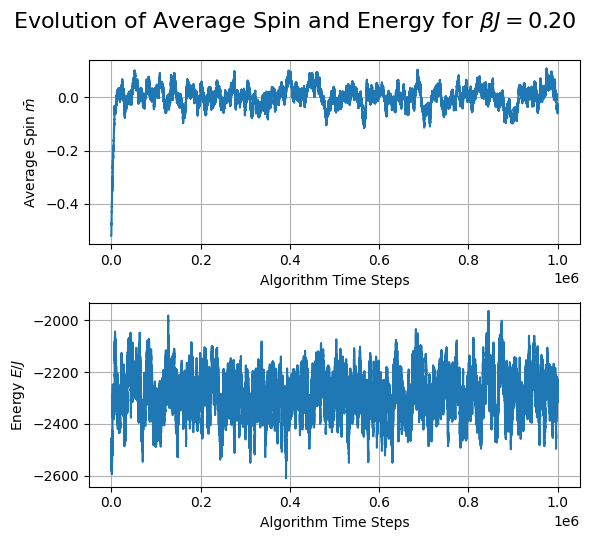

In [75]:
fig, axes = plt.subplots(2, 1, figsize=(6, 5))  # 2 linhas e 1 coluna
ax = axes[0]
ax.plot(spins / N**2)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()

ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()

fig.tight_layout()
fig.suptitle(r'Evolution of Average Spin and Energy for $\beta J=$' + f'{bj:.2f}', y=1.07, size=16)

plt.show()

In [72]:
def get_spin_energy(lattice, BJs):
    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs))
    for i, bj in enumerate(BJs):
        spins, energies = metropolis(lattice, 1000000, bj, get_energy(lattice))
        ms[i] = spins[-100000:].mean()/N**2
        E_means[i] = energies[-100000:].mean()
        E_stds[i] = energies[-100000:].std()
    return ms, E_means, E_stds
    
BJs = np.arange(0.1, 2, 0.05)
ms_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs)
ms_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)


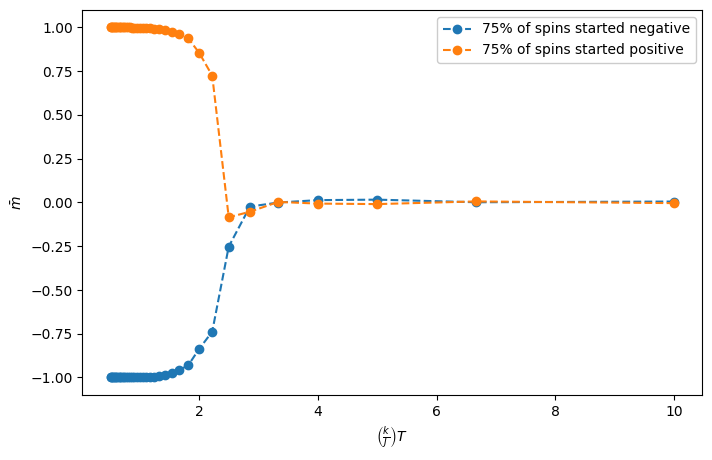

In [76]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs, ms_n, 'o--', label='75% of spins started negative')
plt.plot(1/BJs, ms_p, 'o--', label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

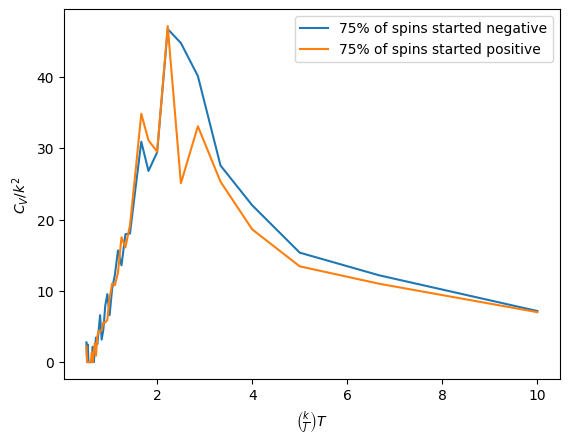

In [77]:
plt.plot(1/BJs, E_stds_n*BJs, label='75% of spins started negative')
plt.plot(1/BJs, E_stds_p*BJs, label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$C_V / k^2$')
plt.legend()
plt.show()

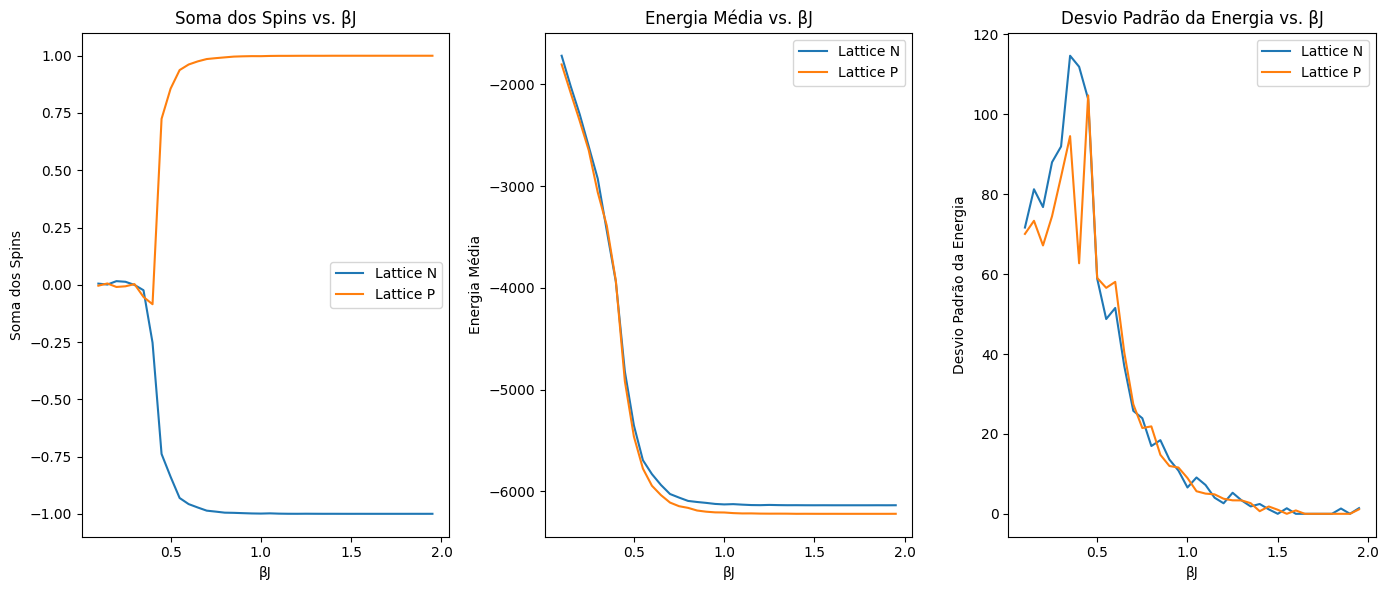

In [78]:
# Visualização dos resultados
plt.figure(figsize=(14, 6))

# Soma dos spins
plt.subplot(1, 3, 1)
plt.plot(BJs, ms_n, label='Lattice N')
plt.plot(BJs, ms_p, label='Lattice P')
plt.title('Soma dos Spins vs. βJ')
plt.xlabel('βJ')
plt.ylabel('Soma dos Spins')
plt.legend()

# Energia média
plt.subplot(1, 3, 2)
plt.plot(BJs, E_means_n, label='Lattice N')
plt.plot(BJs, E_means_p, label='Lattice P')
plt.title('Energia Média vs. βJ')
plt.xlabel('βJ')
plt.ylabel('Energia Média')
plt.legend()

# Desvio padrão da energia
plt.subplot(1, 3, 3)
plt.plot(BJs, E_stds_n, label='Lattice N')
plt.plot(BJs, E_stds_p, label='Lattice P')
plt.title('Desvio Padrão da Energia vs. βJ')
plt.xlabel('βJ')
plt.ylabel('Desvio Padrão da Energia')
plt.legend()

plt.tight_layout()
plt.show()